# AI LAB 4: TRANSFER LEARNING

**Vgg-16 Binary Classification**


### Библиотеки и установка зависимостей

In [3]:
import pickle
import numpy as np
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import OxfordIIITPet
import torchvision
from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from matplotlib import colors, pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

In [4]:
DATA_MODES = ['train', 'val']
RESCALE_SIZE = 224
DEVICE = torch.device("cpu")
BIN = True
if torch.cuda.is_available():
    DEVICE = torch.device("cuda")

In [5]:
def checkBin(filename):
    if filename[0].islower():
        return "Dog"
    return "Cat"

In [6]:
class PetFacesDataset(Dataset):
    def __init__(self, files, mode, bin=False):
        super().__init__()
        self.files = sorted(files)
        self.mode = mode
        self.bin = bin

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            if self.bin:
                self.labels = [checkBin(path.name) for path in self.files]
            else:
                self.labels = ["_".join(path.name.split("_")[0:-1]) for path in self.files]
            self.label_encoder.fit(self.labels)
            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file).convert('RGB')
        image.load()
        return image
  
    def __getitem__(self, index):
        if self.mode == 'train':
            transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.RandomHorizontalFlip(),
                transforms.RandomAutocontrast(),
                transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])
        else:
            transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
            ])
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y
        
    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [7]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [8]:
root = './'
_ = OxfordIIITPet(root, download=True)

100%|██████████| 791918971/791918971 [00:55<00:00, 14185541.30it/s]


Extracting oxford-iiit-pet/images.tar.gz to oxford-iiit-pet


100%|██████████| 19173078/19173078 [00:02<00:00, 7552699.73it/s] 


Extracting oxford-iiit-pet/annotations.tar.gz to oxford-iiit-pet


In [9]:
DIR = Path('./oxford-iiit-pet/images')

files = sorted(list(DIR.rglob('*.jpg')))

In [10]:
from sklearn.model_selection import train_test_split

if BIN:
    y = [checkBin(path.name) for path in files]
else:
    y = ["_".join(path.name.split("_")[0:-1]) for path in files]
print(y)

train_data, val_data = train_test_split(files, train_size=0.8, stratify=y)

['Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat'

In [11]:
train_dataset = PetFacesDataset(train_data, "train", bin=BIN)
val_dataset   = PetFacesDataset(val_data, "val", bin=BIN)

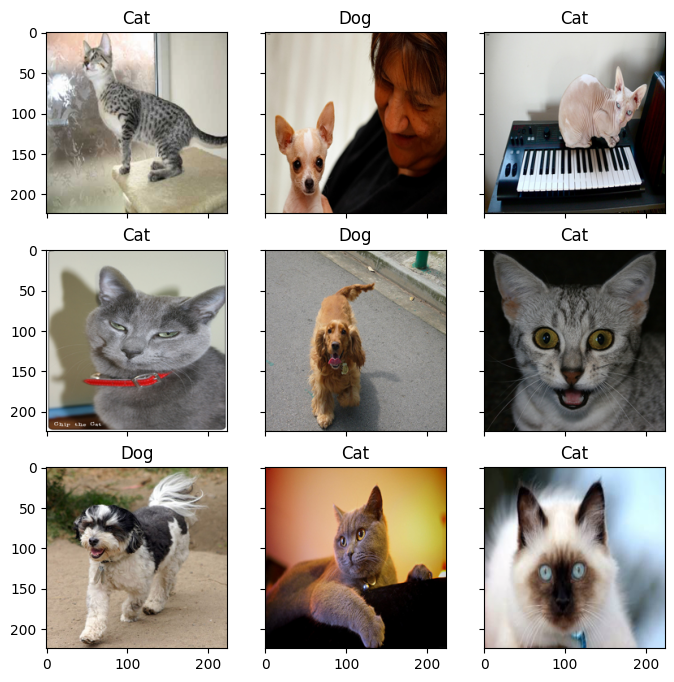

In [12]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

Код для обучения модели

In [13]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0.0
    processed_data = 0.0
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [14]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0.0
    running_corrects_top3 = 0.0
    running_corrects_top5 = 0.0
    processed_size = 0.0
    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)
            preds_top3 = preds
            preds_top5 = preds
            try:
                preds_top3 = torch.topk(outputs, 3).indices
                preds_top5 = torch.topk(outputs, 5).indices
            except:
                "ok"
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        for i in range(len(labels.data)):
            if labels.data[i] in preds_top3[i]:
                running_corrects_top3 += 1
                # print(labels.data[i])
                # print(preds_top3[i])
        for i in range(len(labels.data)):
            if labels.data[i] in preds_top5[i]:
                running_corrects_top5 += 1
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double().cpu().numpy() / processed_size
    val_acc_top3 = running_corrects_top3 / processed_size
    val_acc_top5 = running_corrects_top5 / processed_size
    return val_loss, val_acc, val_acc_top3, val_acc_top5

In [15]:
def train(train_files, val_files, model, epochs, batch_size):
    train_loader = DataLoader(train_files, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_files, batch_size=batch_size, shuffle=False)
    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} val_loss {v_loss:0.4f} \
    train_acc {t_acc:0.4f} val_acc {v_acc:0.4f} \
    val_acc_top3 {v_acc_3:0.4f} val_acc_top5 {v_acc_5:0.4f}"
    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.AdamW(model.parameters(), lr=0.001)
        scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=4, gamma=0.1)
        criterion = nn.CrossEntropyLoss()
        for epoch in range(epochs):
            model.train()
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            scheduler.step()
            model.eval()
            val_loss, val_acc, val_acc_3, val_acc_5 = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc, val_acc_3, val_acc_5))
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
            v_loss=val_loss, t_acc=train_acc, v_acc=val_acc, v_acc_3=val_acc_3,\
            v_acc_5=val_acc_5))
    return history

In [16]:
def predict(model, test_loader):
    logits = []
    with torch.inference_mode():
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

## Обучение

Посмотрим на количество данных и число классов.

In [17]:
print(f"Количествово классов: {len(np.unique(np.array(y)))}")
print(f"Размер обучающей выборки: {len(train_dataset)}")
print(f"Размер валидационной выборки: {len(val_dataset)}")

Количествово классов: 2
Размер обучающей выборки: 5912
Размер валидационной выборки: 1478


В этом блокноте рассматривается **Vgg-16** для **бинарной** классификации

In [18]:
model = torchvision.models.vgg16(weights="IMAGENET1K_V1")
model

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:01<00:00, 281MB/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

Поменяем выход последнего слоя на количество классов (в случае бинарной классификации - 2)

In [19]:
model.classifier[6] = nn.Linear(4096, len(np.unique(np.array(y))))

In [20]:
model = model.to(DEVICE)

Обучаем сеть

In [21]:
history = train(train_dataset, val_dataset, model=model, epochs=7, batch_size=128)

epoch:  14%|█▍        | 1/7 [03:06<18:36, 186.14s/it]


Epoch 001 train_loss: 0.8409 val_loss 0.6291     train_acc 0.6428 val_acc 0.6752     val_acc_top3 0.6752 val_acc_top5 0.6752


epoch:  29%|██▊       | 2/7 [06:06<15:13, 182.75s/it]


Epoch 002 train_loss: 0.6328 val_loss 0.6385     train_acc 0.6752 val_acc 0.6752     val_acc_top3 0.6752 val_acc_top5 0.6752


epoch:  43%|████▎     | 3/7 [09:07<12:07, 181.76s/it]


Epoch 003 train_loss: 0.6223 val_loss 0.6172     train_acc 0.6752 val_acc 0.6752     val_acc_top3 0.6752 val_acc_top5 0.6752


epoch:  57%|█████▋    | 4/7 [12:07<09:03, 181.24s/it]


Epoch 004 train_loss: 0.6099 val_loss 0.5958     train_acc 0.6749 val_acc 0.6752     val_acc_top3 0.6752 val_acc_top5 0.6752


epoch:  71%|███████▏  | 5/7 [15:09<06:03, 181.54s/it]


Epoch 005 train_loss: 0.6012 val_loss 0.5941     train_acc 0.6752 val_acc 0.6752     val_acc_top3 0.6752 val_acc_top5 0.6752


epoch:  86%|████████▌ | 6/7 [18:11<03:01, 181.50s/it]


Epoch 006 train_loss: 0.5910 val_loss 0.5944     train_acc 0.6761 val_acc 0.6793     val_acc_top3 0.6793 val_acc_top5 0.6793


epoch: 100%|██████████| 7/7 [21:16<00:00, 182.40s/it]


Epoch 007 train_loss: 0.5850 val_loss 0.5866     train_acc 0.6818 val_acc 0.6854     val_acc_top3 0.6854 val_acc_top5 0.6854


Построим кривые обучения для первых 7 эпох

In [22]:
loss, acc, val_loss, val_acc, val_acc_3, val_acc_5 = zip(*history)

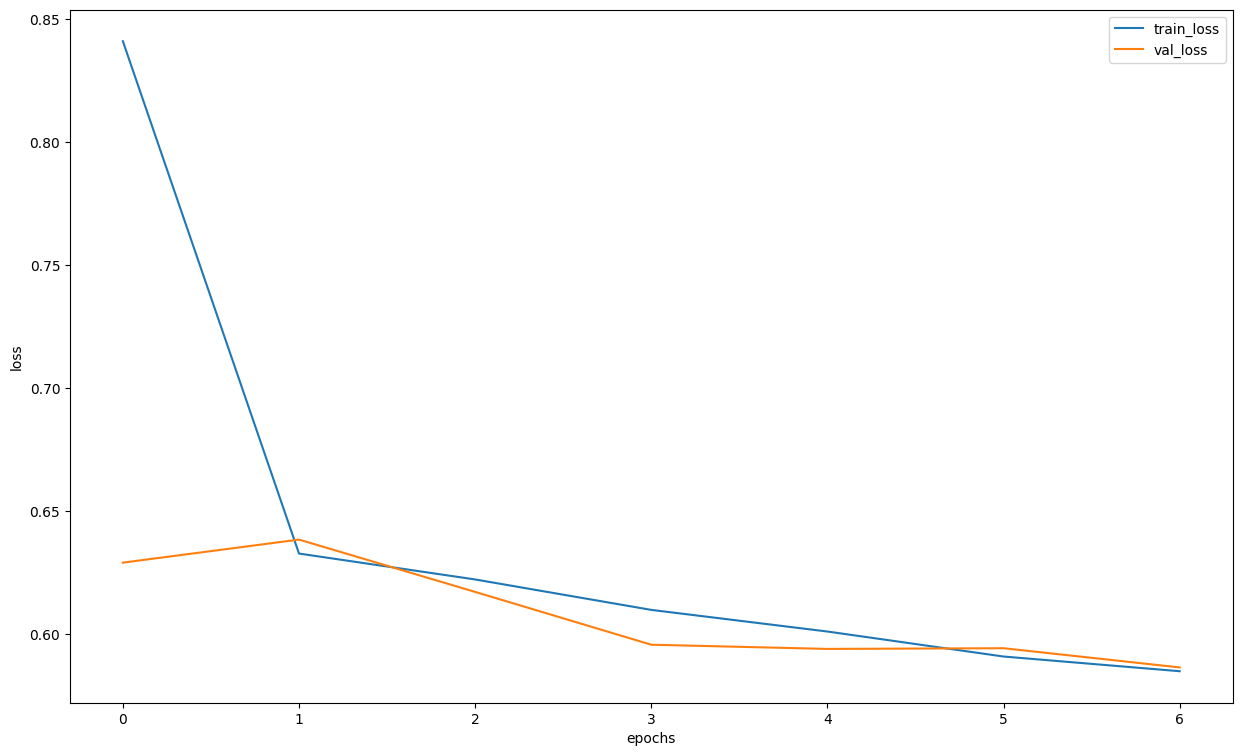

In [23]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

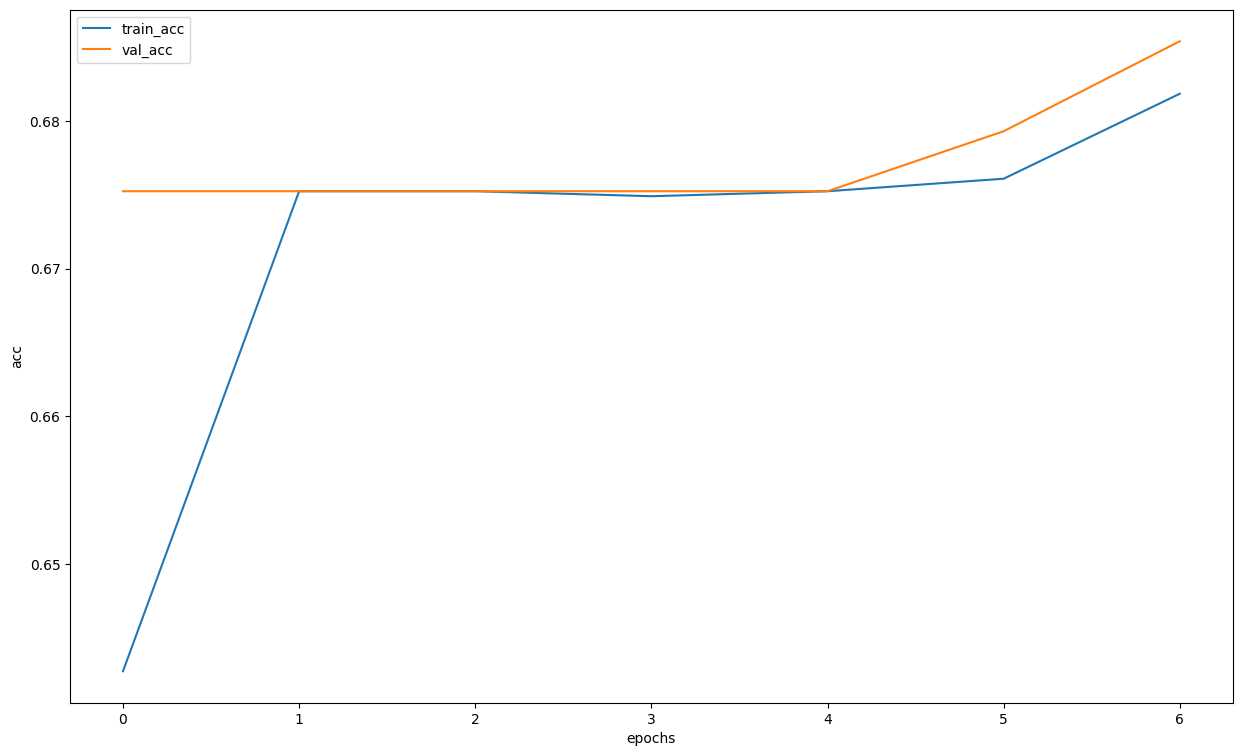

In [24]:
plt.figure(figsize=(15, 9))
plt.plot(acc, label="train_acc")
plt.plot(val_acc, label="val_acc")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("acc")
plt.show()

Дообучим ещё на 5 эпохах

In [25]:
history2 = train(train_dataset, val_dataset, model=model, epochs=5, batch_size=128)

epoch:  20%|██        | 1/5 [03:06<12:26, 186.56s/it]


Epoch 001 train_loss: 0.6304 val_loss 0.6656     train_acc 0.6685 val_acc 0.6752     val_acc_top3 0.6752 val_acc_top5 0.6752


epoch:  40%|████      | 2/5 [06:10<09:15, 185.29s/it]


Epoch 002 train_loss: 0.5971 val_loss 0.5828     train_acc 0.6817 val_acc 0.7037     val_acc_top3 0.7037 val_acc_top5 0.7037


epoch:  60%|██████    | 3/5 [09:15<06:09, 184.95s/it]


Epoch 003 train_loss: 0.5798 val_loss 0.5933     train_acc 0.7031 val_acc 0.7003     val_acc_top3 0.7003 val_acc_top5 0.7003


epoch:  80%|████████  | 4/5 [12:20<03:04, 184.84s/it]


Epoch 004 train_loss: 0.5558 val_loss 0.5392     train_acc 0.7141 val_acc 0.7158     val_acc_top3 0.7158 val_acc_top5 0.7158


epoch: 100%|██████████| 5/5 [15:23<00:00, 184.76s/it]


Epoch 005 train_loss: 0.5053 val_loss 0.5055     train_acc 0.7436 val_acc 0.7314     val_acc_top3 0.7314 val_acc_top5 0.7314


Визуализация предсказаний нейронной сети

In [26]:
def predict_one_sample(model, inputs, device=DEVICE):
    with torch.inference_mode():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

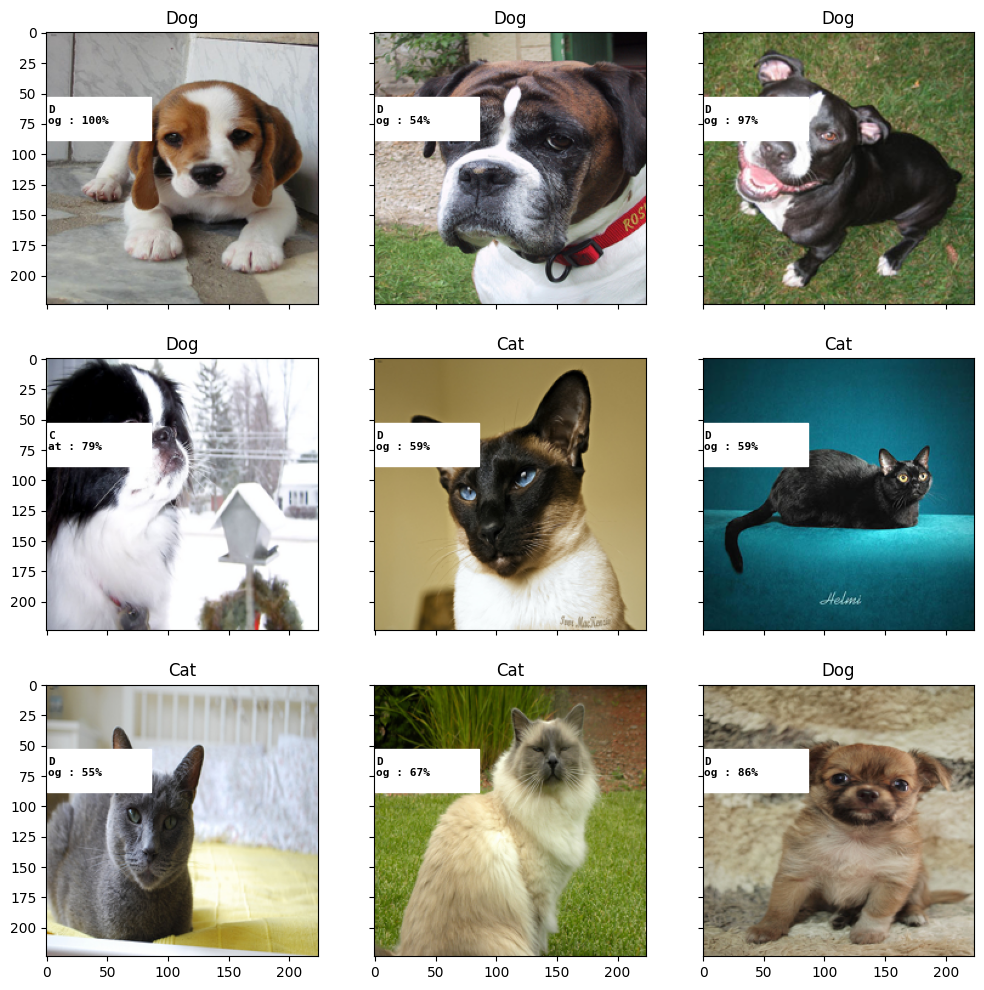

In [27]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0, 1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))

    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)
    
    actual_text = "Actual : {}".format(img_label)
            
    fig_x.add_patch(patches.Rectangle((0, 53), 86, 35, color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("monospace")
    prob_pred = predict_one_sample(model, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred) * 100
    y_pred = np.argmax(prob_pred)
    
    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label) // 2] + '\n' + predicted_label[len(predicted_label) // 2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label, predicted_proba)
            
    fig_x.text(1, 59, predicted_text, horizontalalignment='left', fontproperties=font,
                    verticalalignment='top', fontsize=8, color='black', fontweight='bold')

## Confusion matrix

Матрица ошибок (Confusion matrix) --- это важный инструмент, который используется для оценки производительности модели классификации. Она представляет собой таблицу, которая позволяет визуализировать и анализировать результаты классификации на основе истинных и предсказанных значений.

In [28]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

In [29]:
idxs = list(range(0, len(val_dataset)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]
probs_ims = predict(model, imgs)
y_real = [val_dataset[id][1] for id in idxs]
y_pred = torch.Tensor(probs_ims).argmax(dim=1).tolist()

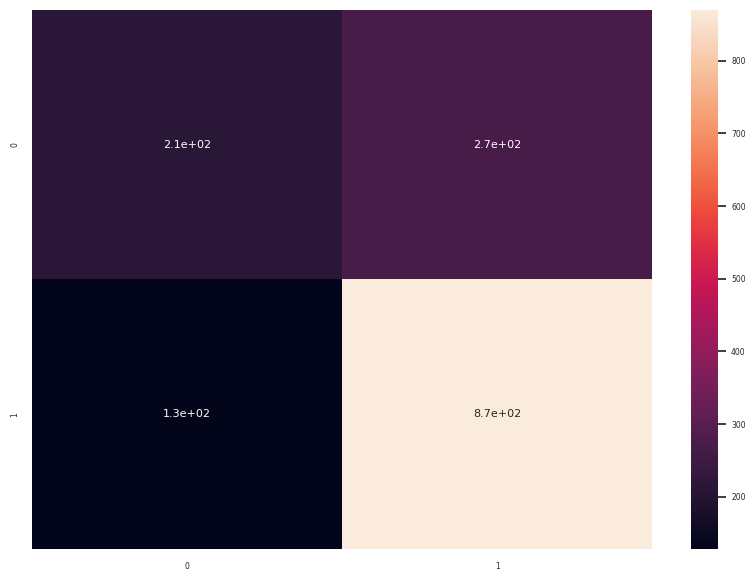

In [30]:
array = confusion_matrix(y_real, y_pred)
df_cm = pd.DataFrame(array, range(2), range(2))
plt.figure(figsize=(10, 7))
sn.set(font_scale=0.5)
sn.heatmap(df_cm, annot=True, annot_kws={"size": 8})
plt.show()

#### Соотношения классов с лейблами


In [31]:
[x for x in zip(train_dataset.label_encoder.classes_,
train_dataset.label_encoder.transform(list(train_dataset.label_encoder.classes_)))]

[('Cat', 0), ('Dog', 1)]